Author: Luca Pappalardo
</br>Geospatial Analytics, Master degree in Data Science and Business Informatics, University of Pisa

# Geospatial Analytics - Lesson 5: Mobility laws and models
- Individual measures
    1. [Jump length](#jumplength)
    2. [Max distance](#maxdistance)
    3. [Distance straight line](#straightline)
    4. [Max distance from home](#distfromhome)
    5. [Radius of gyration](#rg)
    6. [$k$-radius of gyration](#krg)
    7. [Location Frequency](#locfreq)
    8. [Uncorrelated entropy](#uncentropy)
    9. [Individual mobility network](#IMN)
- Collective measures
    1. [Visits per location](#visits_per_location)
    2. [Homes per location](#homes_per_location)
    3. [Visits per time unit](#visits_per_time_unit)
- [Mobility models](#models)

In [78]:
import warnings
warnings.filterwarnings('ignore')

In [79]:
# import the library
import skmob
import pandas as pd
from tqdm import tqdm
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from stats_utils import *
from skmob.utils.plot import *
from skmob.data.load import *
from skmob.tessellation.tilers import tiler

## Measures
We can compute on a `TrajDataFrame` two types of measures:

- *individual measures*, describing features related to the mobility patterns of a single individual
- *collective measures*, describing the mobility patterns of an entire population of individuals

https://scikit-mobility.github.io/scikit-mobility/reference/measures.html

## Loading the data
We load data of checkins made by users on Brightkite, a location-based social network (LBSN).

The dataset is freely available at the SNAP website: https://snap.stanford.edu/data/loc-brightkite.html

In [80]:
# download the dataset using pandas
url = "https://snap.stanford.edu/data/loc-brightkite_totalCheckins.txt.gz"
df = pd.read_csv(url, sep='\t', header=0, nrows=1000000, 
                 names=['user', 'check-in_time', "latitude", "longitude", 
                        "location id"])
df.head()

,user,check-in_time,latitude,longitude,location id
0,0,2010-10-16T06:02:04Z,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2
1,0,2010-10-16T03:48:54Z,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79
2,0,2010-10-14T18:25:51Z,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683
3,0,2010-10-14T00:21:47Z,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc
4,0,2010-10-13T23:31:51Z,39.752508,-104.996637,424eb3dd143292f9e013efa00486c907


In [81]:
# convert the pandas DataFrame into an skmob TrajDataFrame
tdf = skmob.TrajDataFrame(df, latitude='latitude', 
            longitude='longitude', datetime='check-in_time', user_id='user')
print(tdf.shape)
tdf.head()

(1000000, 5)


,uid,datetime,lat,lng,location id
0,0,2010-10-16 06:02:04+00:00,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2
1,0,2010-10-16 03:48:54+00:00,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79
2,0,2010-10-14 18:25:51+00:00,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683
3,0,2010-10-14 00:21:47+00:00,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc
4,0,2010-10-13 23:31:51+00:00,39.752508,-104.996637,424eb3dd143292f9e013efa00486c907


In [82]:
print("number of users:\t", len(tdf.uid.unique()))
print("number of records:\t", len(tdf))

number of users:	 2757
number of records:	 1000000


In [83]:
plot_points_heatmap(tdf, map_f=None, max_points=1000, 
                        tiles='cartodbpositron', zoom=2,
                       min_opacity=0.5, radius=25, blur=15,
                       gradient=None);

## Individual measures
Computed on the trajectories, quantify standard mobility patterns.

<a id='jumplength'></a>
### Jump lengths
- a jump length is the distance between two consecutive visits of an individual
- given a `TrajDataFrame`, skmob computes the lengths for each individual independently
- use the `jump_lengths` function

In [84]:
from skmob.measures.individual import jump_lengths

In [85]:
jl_df = jump_lengths(tdf) # disable progress bar with show_progress=False
jl_df.head()

  2%|▏         | 42/2757 [00:00<00:18, 148.88it/s]

100%|██████████| 2757/2757 [00:06<00:00, 424.21it/s]


,uid,jump_lengths
0,0,"[19.64046732887831, 0.0, 0.0, 1.74343110103816..."
1,1,"[6.505330424378811, 46.754366003759536, 53.928..."
2,2,"[0.0, 0.0, 0.0, 0.0, 3.641009719594163, 0.0, 5..."
3,3,"[3861.270630079885, 4.061631313492122, 5.91632..."
4,4,"[15511.92758595804, 0.0, 15511.92758595804, 1...."


In [86]:
# merge=True put all distances of the individuals into a single list
jl_list = jump_lengths(tdf, merge=True)

  0%|          | 6/2757 [00:00<00:46, 59.02it/s]

100%|██████████| 2757/2757 [00:05<00:00, 482.45it/s]


In [87]:
type(jl_list)

list

In [88]:
print(len(jl_list))
#One or all user? You have the answer...
print(len(tdf)-len(tdf.uid.unique()))

997243
997243


In [89]:
jl_list[:10]

[19.64046732887831,
 0.0,
 0.0,
 1.743431101038163,
 1553.5011134765616,
 0.0,
 30.14517724008101,
 0.0,
 2.563647571198179,
 1.9309489380903868]

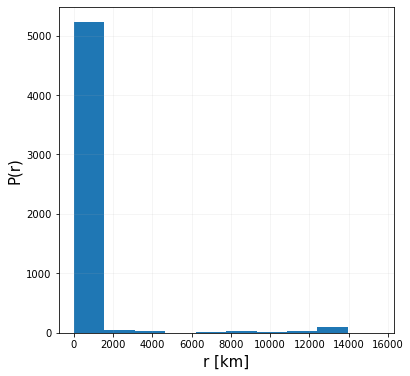

In [90]:
# let's plot the distribution of jump lengths
fig = plt.figure(figsize=(6, 6))
d_list = [dist for dist in jl_list[:10000] if dist >= 1]
plt.hist(d_list)
plt.xlabel('r [km]', fontsize=15)
plt.ylabel('P(r)', fontsize=15)
plt.grid(alpha=0.15)
plt.show()

In [91]:
x, y = zip(*lbpdf(1.5, [r for r in jl_list if r > 1.0]))

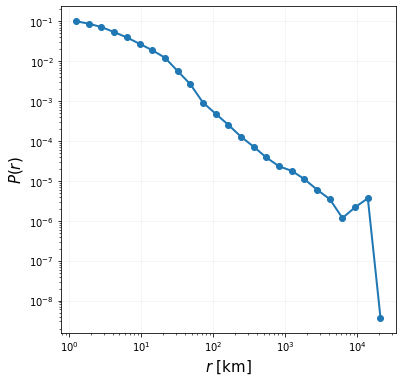

In [92]:
# let's plot the distribution of jump lengths
fig = plt.figure(figsize=(6, 6))
plt.plot(x, y, marker='o', linewidth=2)
plt.loglog()
plt.xlabel('$r$ [km]', fontsize=15)
plt.ylabel('$P(r)$', fontsize=15)
plt.grid(alpha=0.15)
plt.show()

<a id="maxdistance"></a>
### Max distance
- maximum distance traveled by each individual 
- use function `maximum_distance`

In [93]:
from skmob.measures.individual import maximum_distance

In [94]:
md_df = maximum_distance(tdf)
md_df.head()

  0%|          | 0/2757 [00:00<?, ?it/s]

100%|██████████| 2757/2757 [00:05<00:00, 513.09it/s]


,uid,maximum_distance
0,0,11294.436420
1,1,12804.895064
2,2,11286.745660
3,3,12803.259219
4,4,15511.927586


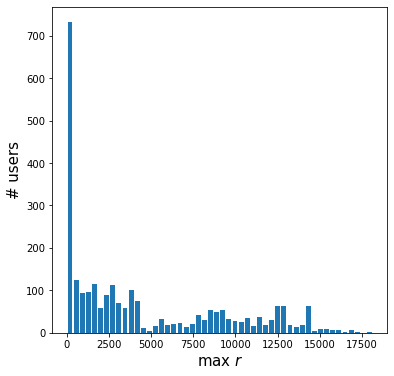

In [95]:
# let's plot the distribution
fig = plt.figure(figsize=(6, 6))
plt.hist(md_df['maximum_distance'], bins=50, rwidth=0.8)
plt.xlabel('max $r$', fontsize=15)
plt.ylabel('# users', fontsize=15)
plt.show()

In [96]:
md_df = md_df[md_df['maximum_distance'] > 1]

In [97]:
x, y = zip(*lbpdf(1.5, list(md_df['maximum_distance'])))

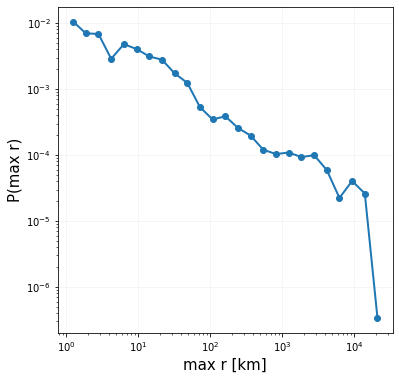

In [98]:
# let's plot the distribution of max distance
fig = plt.figure(figsize=(6, 6))
plt.plot(x, y, marker='o', linewidth=2)
plt.loglog()
plt.xlabel('max r [km]', fontsize=15)
plt.ylabel('P(max r)', fontsize=15)
plt.grid(alpha=0.15)
plt.show()

<a id="straightline"></a>
### Distance straight line
- distance straight line traveled by each individual
- use function `distance_straight_line`

In [99]:
from skmob.measures.individual import distance_straight_line

In [100]:
dsl_df = distance_straight_line(tdf)
dsl_df.head()

  0%|          | 0/2757 [00:00<?, ?it/s]

100%|██████████| 2757/2757 [00:06<00:00, 428.61it/s]


,uid,distance_straight_line
0,0,374530.954882
1,1,774346.816009
2,2,88710.682464
3,3,470986.771764
4,4,214623.524252


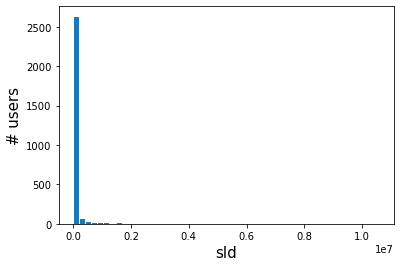

In [101]:
# let's plot the distribution
fig = plt.figure()
plt.hist(dsl_df['distance_straight_line'], bins=50, rwidth=0.8)
plt.xlabel('sld', fontsize=15)
plt.ylabel('# users', fontsize=15)
plt.show()

In [102]:
dsl_df = dsl_df[dsl_df['distance_straight_line'] > 1]

In [103]:
x, y = zip(*lbpdf(1.5, list(dsl_df['distance_straight_line'])))

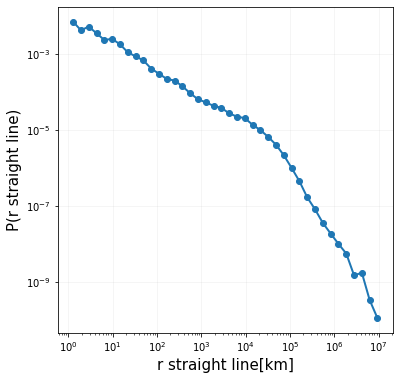

In [104]:
# let's plot the distribution 
fig = plt.figure(figsize=(6, 6))
plt.plot(x, y, marker='o', linewidth=2)
plt.loglog()
plt.xlabel('r straight line[km]', fontsize=15)
plt.ylabel('P(r straight line)', fontsize=15)
plt.grid(alpha=0.15)
plt.show()

<a id="distfromhome"></a>
### Max distance from home
- compute the maximum distance traveled by an individual from their home
- use the function `max_distance_from_home`

In [105]:
from skmob.measures.individual import max_distance_from_home

In [106]:
mdh_df = max_distance_from_home(tdf)
mdh_df.head()

  1%|          | 18/2757 [00:00<00:30, 89.68it/s]

100%|██████████| 2757/2757 [00:18<00:00, 152.69it/s]


,uid,max_distance_from_home
0,0,11286.942949
1,1,12800.547682
2,2,11282.748348
3,3,12799.754644
4,4,15512.788707


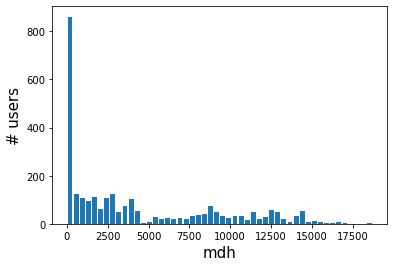

In [107]:
# let's plot the distribution
fig = plt.figure()
plt.hist(mdh_df['max_distance_from_home'], bins=50, rwidth=0.8)
plt.xlabel('mdh', fontsize=15)
plt.ylabel('# users', fontsize=15)
plt.show()

In [108]:
mdh_df = mdh_df[mdh_df['max_distance_from_home'] > 1]

In [109]:
x, y = zip(*lbpdf(1.5, list(mdh_df['max_distance_from_home'])))

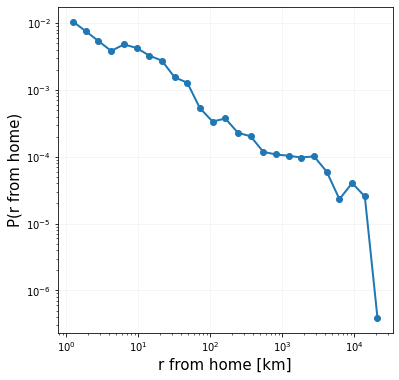

In [110]:
# let's plot the distribution 
fig = plt.figure(figsize=(6, 6))
plt.plot(x, y, marker='o', linewidth=2)
plt.loglog()
plt.xlabel('r from home [km]', fontsize=15)
plt.ylabel('P(r from home)', fontsize=15)
plt.grid(alpha=0.15)
plt.show()

<a id="rg"></a>
### Radius of gyration $r_g$
characteristic distance traveled by an individual:

$$r_g = \sqrt{\frac{1}{N} \sum_{i=1}^N (\mathbf{r}_i - \mathbf{r}_{cm})^2}$$

$r_{cm}$ is the position vector of the center of mass of the set of locations visited by the individual

In [111]:
from skmob.measures.individual import radius_of_gyration

In [112]:
rg_df = radius_of_gyration(tdf)
rg_df.head()

  0%|          | 0/2757 [00:00<?, ?it/s]

100%|██████████| 2757/2757 [00:04<00:00, 653.62it/s] 


,uid,radius_of_gyration
0,0,1564.436792
1,1,2467.773523
2,2,1439.649774
3,3,1752.604191
4,4,5380.503250


In [113]:
type(rg_df)

pandas.core.frame.DataFrame

<AxesSubplot:ylabel='Frequency'>

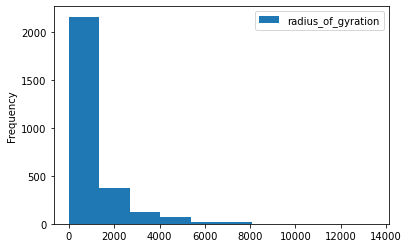

In [114]:
rg_df.plot(kind='hist', y='radius_of_gyration')

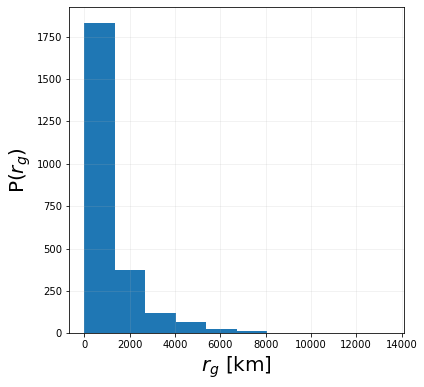

In [115]:
# let's plot the distribution
fig = plt.figure(figsize=(6, 6))
rg_list = list(rg_df.radius_of_gyration[rg_df.radius_of_gyration >= 1.0])
plt.hist(rg_list)
plt.xlabel('$r_g$ [km]', fontsize=20);plt.ylabel('P($r_g$)', fontsize=20)
plt.grid(alpha=0.2)
plt.show()

In [116]:
rg_df = rg_df[rg_df['radius_of_gyration'] > 1]


In [117]:
x, y = zip(*lbpdf(1.5, list(rg_df['radius_of_gyration'])))

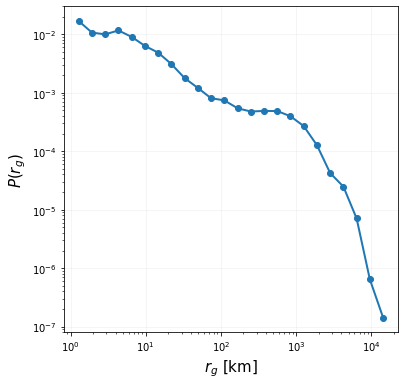

In [118]:
# let's plot the distribution
fig = plt.figure(figsize=(6, 6))
plt.plot(x, y, marker='o', linewidth=2)
plt.loglog()
plt.xlabel('$r_g$ [km]', fontsize=15)
plt.ylabel('$P(r_g)$', fontsize=15)
plt.grid(alpha=0.15)
plt.show()

<a id="krg"></a>
### $k$-radius of gyration $r_g^{(k)}$
recurrent distance traveled by an individual:

$$r_g^{(k)} = \sqrt{\frac{1}{N_k} \sum_{i=1}^k (\mathbf{r}_i - \mathbf{r}_{cm}^{(k)})^2}$$

$r_{cm}^{(k)}$ is the position vector of the center of mass of the set $k$ most visited locations

In [119]:
from skmob.measures.individual import k_radius_of_gyration

In [120]:
krg_df = k_radius_of_gyration(tdf, k=2)

  0%|          | 0/2757 [00:00<?, ?it/s]

100%|██████████| 2757/2757 [00:11<00:00, 247.69it/s]


In [121]:
krg_df.head()

,uid,2k_radius_of_gyration
0,0,7.858833
1,1,4.069300
2,2,5.878727
3,3,10.622092
4,4,0.740360


In [122]:
rgs_df = pd.merge(rg_df, krg_df, on='uid')
rgs_df.head()

,uid,radius_of_gyration,2k_radius_of_gyration
0,0,1564.436792,7.858833
1,1,2467.773523,4.069300
2,2,1439.649774,5.878727
3,3,1752.604191,10.622092
4,4,5380.503250,0.740360


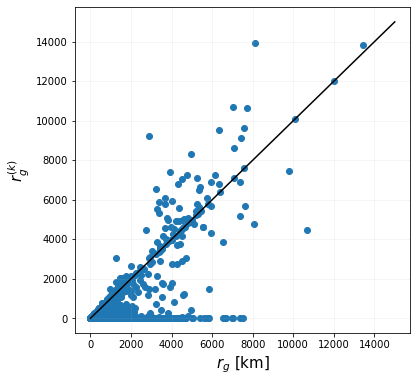

In [123]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(rgs_df['radius_of_gyration'], rgs_df['2k_radius_of_gyration'], marker='o')
plt.xlabel('$r_g$ [km]', fontsize=15)
plt.ylabel('$r_g^{(k)}$', fontsize=15)
plt.grid(alpha=0.15)
plt.plot([0, 15000], [0, 15000], color="black")
plt.show()

<a id='locfreq'></a>
### Location frequency
- compute the frequency of visiting each location
- use the function `location_frequency`

In [124]:
from skmob.measures.individual import location_frequency

In [125]:
lf_df = location_frequency(tdf, normalize=True).reset_index()
lf_df.head()

  0%|          | 0/2757 [00:00<?, ?it/s]

100%|██████████| 2757/2757 [00:04<00:00, 578.06it/s]


,uid,lat,lng,location_frequency
0,0,39.762146,-104.982480,0.101953
1,0,39.891077,-105.068532,0.065269
2,0,39.739154,-104.984703,0.060029
3,0,39.891586,-105.068463,0.034302
4,0,39.827022,-105.143191,0.025250


In [126]:
a_user_lf_df = lf_df[lf_df['uid'] == 1]
a_user_lf_df.head()

,uid,lat,lng,location_frequency
542,1,37.630490,-122.411084,0.245455
543,1,37.580304,-122.343679,0.222314
544,1,37.584103,-122.366083,0.205785
545,1,37.613825,-122.486919,0.041322
546,1,0.000000,0.000000,0.038017


In [127]:
#check: the locationf req is calculated per each user
a_user_lf_df['location_frequency'].sum()

1.0

In [128]:
# double check...
print(lf_df['location_frequency'].sum())
print(tdf['uid'].nunique())

2756.9999999999995
2757


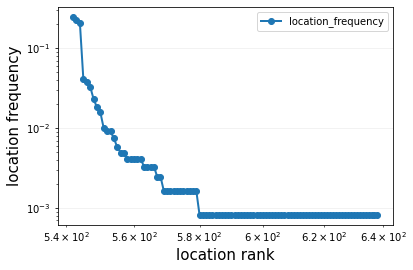

In [129]:
a_user_lf_df.plot(y='location_frequency', linewidth=2, marker='o')
plt.loglog()
plt.xlabel('location rank', fontsize=15)
plt.ylabel('location frequency', fontsize=15)
plt.grid(alpha=0.2)
plt.show()

From `skmob` documentation:

as_ranks : boolean, optional
        if True, return a list where element $i$ indicates the average visitation frequency of the $i$-th most frequent location. The default is False.

In [130]:
new_lf_df = location_frequency(tdf, as_ranks=True)
type(new_lf_df)

  0%|          | 0/2757 [00:00<?, ?it/s]

100%|██████████| 2757/2757 [00:05<00:00, 543.49it/s]


list

In [131]:
new_lf_df

[0.38349229794748263,
 0.15006857422467806,
 0.08003044853153182,
 0.05460792609782499,
 0.041225410891224674,
 0.03348335756473763,
 0.028155636540070486,
 0.024390045551966655,
 0.021827217008450285,
 0.019422576316987572,
 0.017905268883078324,
 0.01648313033065224,
 0.015134168510750301,
 0.014097655528047613,
 0.013299505060738332,
 0.012526829013464153,
 0.011831104831818528,
 0.01130251200150891,
 0.010787541072968788,
 0.010223687869973994,
 0.00970622914222722,
 0.009305433902368253,
 0.008859282535992595,
 0.008580994461349925,
 0.00826885610858178,
 0.00798256240021237,
 0.007733983652083938,
 0.007472029057531096,
 0.0071913472666170096,
 0.0070155088413186165,
 0.006827737016956377,
 0.006598986618182634,
 0.0063678234541273224,
 0.006229804220675777,
 0.006048615845993413,
 0.005915865463972316,
 0.00577950705783234,
 0.00568520307771083,
 0.005521341051221435,
 0.005350600742116163,
 0.005274175940628704,
 0.005160589501370595,
 0.005067307751425697,
 0.00488651073941529

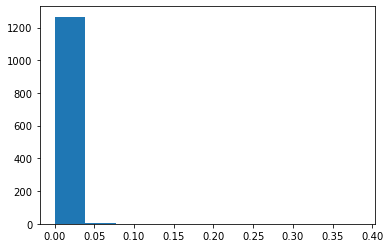

In [132]:
plt.hist(new_lf_df)
plt.show()


#a lot of different not-frequent places, a few very frequent places

<a id="uncentropy"></a>
### Uncorrelated entropy

The predictability of an individual considering the spatial dimension only:

$$ S^{unc} = - \sum_{i=1}^N p_i \log_2(p_i)$$

In [133]:
from skmob.measures.individual import uncorrelated_entropy

In [134]:
s_unc_df = uncorrelated_entropy(tdf, normalize=True)
s_unc_df.head()

  0%|          | 0/2757 [00:00<?, ?it/s]

100%|██████████| 2757/2757 [00:05<00:00, 463.22it/s]


,uid,norm_uncorrelated_entropy
0,0,0.819430
1,1,0.552972
2,2,0.764304
3,3,0.794553
4,4,0.756421


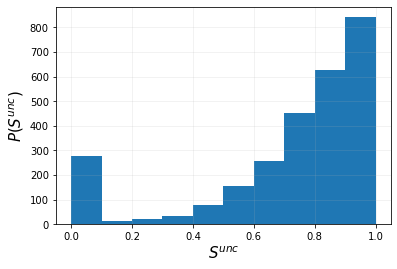

In [135]:
plt.hist(s_unc_df['norm_uncorrelated_entropy'])
plt.xlabel('$S^{unc}$', fontsize=15)
plt.ylabel('$P(S^{unc})$', fontsize=15)
plt.grid(alpha=0.2)
plt.show()

#a lot of very predictable users, a few very unpredictable users: In the few unpredictble some of them are very unpredictable.
#EPR?

<a id="IMN"></a>
### Individual mobility network
it is a network where:

- nodes represent locations visited by the individual
- directed edges represent trips between the locations made by the individual

In [136]:
from skmob.measures.individual import individual_mobility_network

In [137]:
imn_df = individual_mobility_network(tdf)
imn_df.head()

  0%|          | 0/2757 [00:00<?, ?it/s]

100%|██████████| 2757/2757 [00:05<00:00, 496.99it/s]


,uid,lat_origin,lng_origin,lat_dest,lng_dest,n_trips
0,0,37.774929,-122.419415,37.600747,-122.382376,1
1,0,37.600747,-122.382376,37.615223,-122.389979,1
2,0,37.600747,-122.382376,37.580304,-122.343679,1
3,0,37.615223,-122.389979,39.878664,-104.682105,1
4,0,37.615223,-122.389979,37.580304,-122.343679,1


In [138]:
an_imn = imn_df[imn_df.uid == 2]
an_imn.sort_values(by='n_trips', ascending=False).head()

,uid,lat_origin,lng_origin,lat_dest,lng_dest,n_trips
1686,2,39.758302,-104.936129,39.802002,-105.095430,69
1452,2,39.802002,-105.095430,39.758302,-104.936129,59
1493,2,39.739154,-104.984703,39.802002,-105.095430,52
1446,2,39.802002,-105.095430,39.739154,-104.984703,51
1535,2,39.739154,-104.984703,39.818040,-105.081949,23


In [139]:
import networkx as nx
from tqdm import tqdm

In [140]:
a_user_imn_df = imn_df[imn_df['uid'] == 3]
print(len(a_user_imn_df))
a_user_imn_df.head()

1054


,uid,lat_origin,lng_origin,lat_dest,lng_dest,n_trips
2413,3,29.894691,-81.314517,37.758839,-122.388345,1
2414,3,29.894691,-81.314517,29.800407,-81.319127,1
2415,3,37.758839,-122.388345,37.795105,-122.393861,1
2416,3,37.795105,-122.393861,37.752539,-122.434248,1
2417,3,37.795105,-122.393861,37.806327,-122.405041,1


In [141]:
g = nx.DiGraph()

In [142]:
for i, row in a_user_imn_df.iterrows():
    origin = (row['lat_origin'], row['lng_origin'])
    destination = (row['lat_dest'], row['lng_dest'])
    g.add_edge(origin, destination, weight=row['n_trips'])

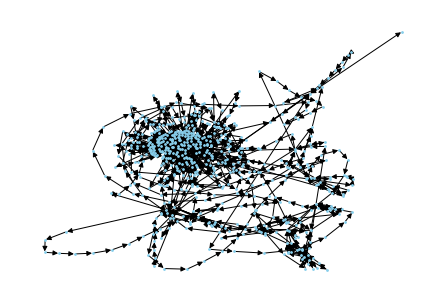

In [143]:
nx.draw(g, node_size=3, node_color="skyblue")

In [144]:
#calculate weighted out degree in g per each node
out_degree = dict(g.out_degree(weight='weight'))
#sort the dict by value
out_degree = sorted(out_degree.items(), key=lambda x: x[1], reverse=True)

out_degree

[((37.74817, -122.459192), 147),
 ((37.580304, -122.343679), 139),
 ((37.776736, -122.394744), 128),
 ((37.776804, -122.393692), 85),
 ((37.579361, -122.346108), 39),
 ((37.753798, -122.455423), 33),
 ((37.751597, -122.447749), 21),
 ((37.775566, -122.393478), 17),
 ((0.0, 0.0), 16),
 ((37.740104, -122.438231), 13),
 ((37.579409, -122.345916), 12),
 ((37.78757, -122.403391), 11),
 ((37.739761, -122.467074), 11),
 ((37.584103, -122.366083), 10),
 ((37.785091, -122.411155), 9),
 ((37.577765, -122.348001), 9),
 ((37.753709, -122.454319), 9),
 ((37.768756, -122.428293), 7),
 ((37.774929, -122.419415), 7),
 ((37.784971, -122.407012), 6),
 ((43.678534, -72.261838), 6),
 ((43.669169, -72.022158), 6),
 ((37.787196, -122.397776), 5),
 ((37.769006, -122.427672), 5),
 ((37.787428, -122.403346), 5),
 ((37.741299, -122.465981), 5),
 ((37.748, -122.463), 5),
 ((37.787305, -122.398037), 5),
 ((37.745056, -122.452445), 5),
 ((37.744731, -122.45299), 5),
 ((37.615223, -122.389979), 5),
 ((37.76583, -12

In [145]:
from skmob.measures.individual import home_location

hl_df = home_location(tdf[tdf['uid'] == 3])

hl_df.head()

100%|██████████| 1/1 [00:00<00:00, 232.13it/s]


,uid,lat,lng
0,3,37.74817,-122.459192


In [146]:
print(out_degree[0][0])
print((hl_df['lat'].values[0], hl_df['lng'].values[0]))

(37.74817, -122.459192)
(37.74817, -122.459192)


You may custommize the visualization of the network: https://www.python-graph-gallery.com/321-custom-networkx-graph-appearance

## Collective measures
are computed on the trajectories of all individual together and quantify standard collective mobility patterns

<a id="visits_per_location"></a>
### Visits per location
number of visits to a location made by the population of individuals

In [147]:
from skmob.measures.collective import visits_per_location

In [148]:
vpl_df = visits_per_location(tdf)
vpl_df.head()

,lat,lng,n_visits
0,0.000000,0.000000,20397
1,39.739154,-104.984703,11949
2,40.014986,-105.270546,5893
3,37.774929,-122.419415,4993
4,40.714269,-74.005973,3626


Text(0.5, 0, 'number of visits')

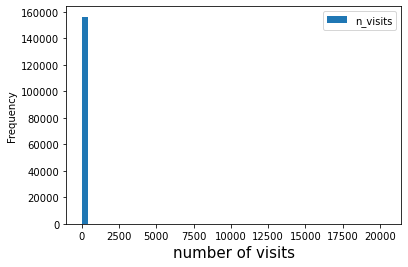

In [149]:
vpl_df.plot(kind='hist', y='n_visits', bins=50)
plt.xlabel('number of visits', fontsize=15)

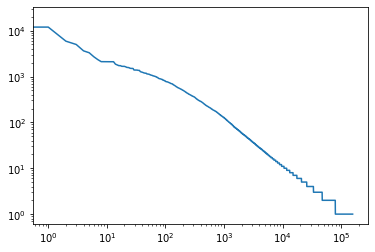

In [150]:
vpl_df['n_visits'].plot()
plt.loglog()
plt.show()

<a id="homes_per_location"></a>
### Homes per location
Compute the number of home locations in each location 

In [151]:
from skmob.measures.collective import homes_per_location

In [152]:
hpl_df = homes_per_location(tdf)
hpl_df.head()

  0%|          | 0/2757 [00:00<?, ?it/s]

100%|██████████| 2757/2757 [00:06<00:00, 457.31it/s]


,lat,lng,n_homes
0,39.739154,-104.984703,99
1,40.014986,-105.270546,51
2,37.774929,-122.419415,46
3,0.000000,0.000000,44
4,30.267153,-97.743061,23


<AxesSubplot:ylabel='Frequency'>

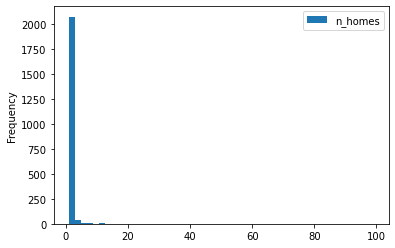

In [153]:
hpl_df.plot(kind='hist', y='n_homes', bins=50)

<a id="visits_per_time_unit"></a>
### Visits per time unit

In [154]:
from skmob.measures.collective import visits_per_time_unit

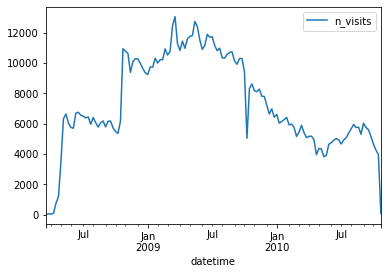

In [155]:
visits_per_time_unit(tdf, time_unit='1w').plot()
plt.show()

<a id="models"></a>
## Mobility models

https://scikit-mobility.github.io/scikit-mobility/reference/models.html#

We want to simulate the mobility of **500** individuals moving in **New York City** for **30 days** with four different generative models:
1. Density-EPR (d-epr)
2. Spatial-EPR (s-epr)
3. Ditras
4. STS-EPR

In [156]:
# set the dates to simulates 30 days

start = pd.to_datetime('2022/10/01 00:00:00')
end = pd.to_datetime('2022/10/30 00:00:00')

In [157]:
# get a tessellation of NYC

tessellation = tiler.get("squared", base_shape="New York City", meters=3000)

In [159]:
tessellation

,tile_ID,geometry
0,0,"POLYGON ((-74.25884 40.47658, -74.25884 40.497..."
1,1,"POLYGON ((-74.25884 40.49707, -74.25884 40.517..."
2,2,"POLYGON ((-74.25884 40.51756, -74.25884 40.538..."
3,3,"POLYGON ((-74.25884 40.53805, -74.25884 40.558..."
4,4,"POLYGON ((-74.25884 40.55853, -74.25884 40.579..."
...,...,...
279,279,"POLYGON ((-73.74680 40.74254, -73.74680 40.762..."
280,280,"POLYGON ((-73.74680 40.76296, -73.74680 40.783..."
281,281,"POLYGON ((-73.71985 40.72212, -73.71985 40.742..."
282,282,"POLYGON ((-73.71985 40.74254, -73.71985 40.762..."


Load real mobility traces of people moving in New York City

In [160]:
%%time

tdf_nyc = tdf.mapping(tessellation, remove_na=True)

CPU times: user 1.03 s, sys: 243 ms, total: 1.28 s
Wall time: 1.31 s


In [161]:
tdf_nyc
#pay attention to the last column: the tessellation id

,uid,datetime,lat,lng,location id,tile_ID
766,0,2010-01-19 19:29:02+00:00,40.766667,-73.866667,79c0489f2044e230bccf9df2fcf2ca89,186
767,0,2010-01-19 18:20:24+00:00,40.766667,-73.866667,79c0489f2044e230bccf9df2fcf2ca89,186
768,0,2010-01-19 16:19:10+00:00,40.757257,-73.983874,09b0e551693b7f074cb77da4f4da8809,105
769,0,2010-01-19 04:21:55+00:00,40.755981,-73.984650,0a47083ab012e3af999b431a38318ff6,105
770,0,2010-01-19 03:56:03+00:00,40.755981,-73.984650,0a47083ab012e3af999b431a38318ff6,105
...,...,...,...,...,...,...
995191,2900,2008-11-15 20:04:20+00:00,40.735994,-74.005102,bb90df0c8cde11ddaed6003048c0801e,89
995192,2900,2008-11-15 19:17:16+00:00,40.724376,-73.997962,a052db76b34111dda3d7003048c10834,89
995193,2900,2008-11-15 09:48:04+00:00,40.690856,-73.996652,188522d4b2f211ddacce003048c0801e,87
995194,2900,2008-11-15 08:09:41+00:00,40.691147,-73.995010,5b83512cb2e411dd9170003048c0801e,87


In [162]:
plot_points_heatmap(tdf_nyc, map_f=None, zoom=8, radius=25, blur=15)

**Weighted tessellation** <br>
We map each point with the corresponding tile to compute a weighted tessellation at each tile is associated its relevance, namely the popularity of a location among real individuals. The overall number of visits to a location is usually used as an estimation of its relevance.

In [163]:
visits_per_tile = tdf_nyc.groupby("tile_ID", as_index=False).count()
visits_per_tile.head()
#every column is counting the number of trajectories. Let's picl an integer one, uid

,tile_ID,uid,datetime,lat,lng,location id
0,10,1,1970-01-01 00:00:00.000000001,1.0,1.0,1
1,100,17,1970-01-01 00:00:00.000000017,17.0,17.0,17
2,101,742,1970-01-01 00:00:00.000000742,742.0,742.0,742
3,102,434,1970-01-01 00:00:00.000000434,434.0,434.0,434
4,103,393,1970-01-01 00:00:00.000000393,393.0,393.0,393


In [164]:
visits_per_tile = visits_per_tile[["tile_ID", "uid"]]
visits_per_tile["relevance"] = visits_per_tile["uid"]
visits_per_tile = visits_per_tile[["tile_ID", "relevance"]]
visits_per_tile.head()

,tile_ID,relevance
0,10,1
1,100,17
2,101,742
3,102,434
4,103,393


In [165]:
#pick only the one in tessellation
weighted_tessellation = tessellation.set_index("tile_ID").join(visits_per_tile.set_index("tile_ID"))
weighted_tessellation = weighted_tessellation.fillna(0)

weighted_tessellation_pos = weighted_tessellation[weighted_tessellation["relevance"]>0] #some relevances are 0

weighted_tessellation_pos

,geometry,relevance
tile_ID,,
9,"POLYGON ((-74.23189 40.55853, -74.23189 40.579...",2.0
10,"POLYGON ((-74.23189 40.57900, -74.23189 40.599...",1.0
24,"POLYGON ((-74.17799 40.55853, -74.17799 40.579...",1.0
25,"POLYGON ((-74.17799 40.57900, -74.17799 40.599...",5.0
26,"POLYGON ((-74.17799 40.59946, -74.17799 40.619...",2.0
...,...,...
277,"POLYGON ((-73.74680 40.70170, -73.74680 40.722...",2.0
278,"POLYGON ((-73.74680 40.72212, -73.74680 40.742...",1.0
279,"POLYGON ((-73.74680 40.74254, -73.74680 40.762...",8.0


### The EPR model

$S$ is the number of distinct locations previously visited by the agent <br>
$\rho$ controls the agent’s tendency to explore a new location during the next (default 0.6) <br>
$\gamma$ controls the agent’s tendency to explore a new location during the next (default 0.21) <br>


<div>
<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fnphys1760/MediaObjects/41567_2010_Article_BFnphys1760_Fig2_HTML.jpg?as=webp" width="400"/>
</div>


### 1. Density-EPR (d-epr)


<b>exploration choice:</b> $p_{ij} = \frac{1}{N} \frac{n_i n_j}{r_{ij}^2}$  <br>
<b>return choice: $\Pi_i = f_i$</b>

$n_{i (j)}$ is the location relevance <br>
$r_{ij}$ is the geographic distance between $i$ and $j$. <br> 
$f_i$ is the visitation frequency of location $i$.

In [167]:
from skmob.models.epr import DensityEPR

depr = DensityEPR()

traj_depr = depr.generate(start, end, weighted_tessellation_pos, relevance_column='relevance', 
                          n_agents=500, show_progress=True)

100%|██████████| 500/500 [00:47<00:00, 10.58it/s]


### 2. Spatial-EPR (s-epr)

<b>exploration choice:</b> $p_{ij} = \frac{1}{r_{ij}^2}$  <br>
<b>return choice: $\Pi_i = f_i$</b>

$r_{ij}$ is the geographic distance between $i$ and $j$. <br> 
$f_i$ is the visitation frequency of location $i$.

In [168]:
from skmob.models.epr import SpatialEPR

sepr = SpatialEPR()

#we don't need the relevance column
traj_sepr = sepr.generate(start, end, weighted_tessellation_pos, n_agents=500, show_progress=True)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:48<00:00, 10.32it/s]


### 3. Ditras

**Mobility Diary Generation**: In the first phase, DITRAS generates a mobility diary which captures the temporal patterns of human mobility.

**Trajectory Generation**: In the second phase, DITRAS transforms the mobility diary into a mobility trajectory which captures the spatial patterns of human movements usign the d-EPR model.


<img src="https://raw.githubusercontent.com/jonpappalord/DITRAS/master/DITRAS_schema.png" width="400"/>



In [169]:
# fit the mobility diary generator

from skmob.models.markov_diary_generator import MarkovDiaryGenerator
from skmob.preprocessing import compression, detection, clustering

ctdf = compression.compress(tdf_nyc)
stdf = detection.stay_locations(ctdf)
cstdf = clustering.cluster(stdf)

mdg_nyc = MarkovDiaryGenerator()

mdg_nyc.fit(cstdf, 500, lid="cluster")

 73%|███████▎  | 365/500 [01:43<00:38,  3.52it/s]


In [170]:
from skmob.models.epr import Ditras

ditras = Ditras(mdg_nyc)

traj_ditras = ditras.generate(start, end, weighted_tessellation_pos, relevance_column='relevance', n_agents=500, 
                              show_progress=True)

100%|██████████| 500/500 [00:07<00:00, 69.97it/s]


### 4. STS-EPR
<div>
<img src="https://i.ibb.co/8X6strg/Cattura.png" width="800"/>
</div>


In [171]:
from skmob.models.sts_epr import STS_epr

sts_epr = STS_epr()

traj_sts = sts_epr.generate(start, end, social_graph="random", n_agents=500, rsl=True,
                                    spatial_tessellation=weighted_tessellation_pos,
                                    diary_generator=mdg_nyc, show_progress=True, relevance_column='relevance')

100%|██████████| 696/696 [00:13<00:00, 50.86it/s] 


### Analysis of the Synthetic Trajectories

In [172]:
synt_dict = {"depr": traj_depr, "sepr": traj_sepr, "ditras": traj_ditras, "sts-epr": traj_sts}

#### 1. Compare the Jump Length of synthetic and real trajectories

In [173]:
# real
jl_list_real = jump_lengths(tdf_nyc, merge=True, show_progress=False)
x_real, y_real = zip(*lbpdf(3, [r for r in jl_list_real if r > 1.0]))


# synth
jl_dist = []
for model in synt_dict:
    jl_list = jump_lengths(synt_dict[model], merge=True, show_progress=False)
    x, y = zip(*lbpdf(3, [r for r in jl_list if r > 1.0]))
    jl_dist.append((model,x,y))

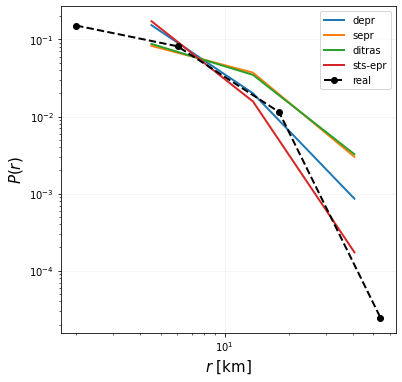

In [177]:
# let's plot the distribution of jump lengths

fig = plt.figure(figsize=(6, 6))

for m, x, y in jl_dist:
     plt.plot(x, y, linewidth=2, label=m)
        
# real
plt.plot(x_real, y_real, marker='o', linewidth=2, label="real", color="black", linestyle="dashed")
    
plt.loglog()
plt.legend()
plt.xlabel('$r$ [km]', fontsize=15)
plt.ylabel('$P(r)$', fontsize=15)
plt.grid(alpha=0.15)
plt.show()

#### 2. $k$-radius of gyration $r_g^{(k)}$ vs. radius of gyration $r_g$

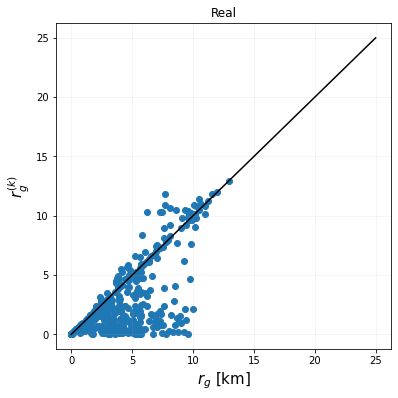

In [178]:
# compute rg and k-rg for real data

rg_real = list(radius_of_gyration(tdf_nyc, show_progress=False)["radius_of_gyration"])
k2rg_real = list(k_radius_of_gyration(tdf_nyc, k=2, show_progress=False)["2k_radius_of_gyration"])

fig = plt.figure(figsize=(6, 6))
plt.title("Real")
plt.scatter(rg_real, k2rg_real, marker='o')
plt.xlabel('$r_g$ [km]', fontsize=15)
plt.ylabel('$r_g^{(k)}$', fontsize=15)
plt.grid(alpha=0.15)
plt.plot([0, 25], [0, 25], color="black")
plt.show()

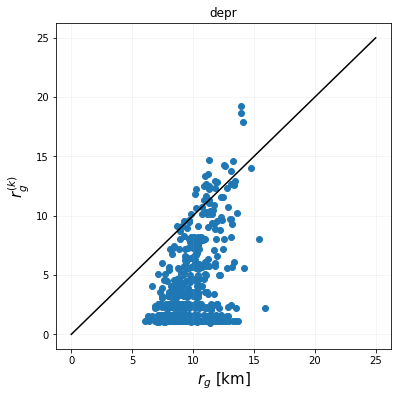

In [91]:
# compute rg and k-rg for sepr

synt_data = synt_dict["sepr"]

rg_syn = list(radius_of_gyration(synt_data, show_progress=False)["radius_of_gyration"])
k2rg_syn = list(k_radius_of_gyration(synt_data, k=2, show_progress=False)["2k_radius_of_gyration"])

fig = plt.figure(figsize=(6, 6))
plt.title("depr")
plt.scatter(rg_syn, k2rg_syn, marker='o')
plt.xlabel('$r_g$ [km]', fontsize=15)
plt.ylabel('$r_g^{(k)}$', fontsize=15)
plt.grid(alpha=0.15)
plt.plot([0, 25], [0, 25], color="black")
plt.show()

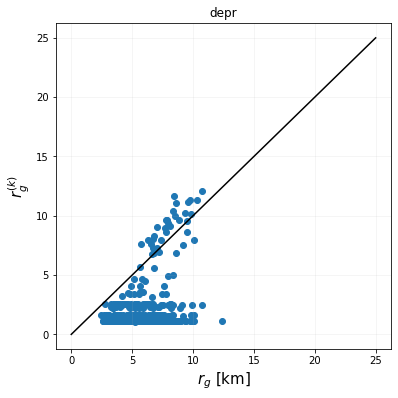

In [179]:
# compute rg and k-rg for depr

synt_data = synt_dict["depr"]

rg_syn = list(radius_of_gyration(synt_data, show_progress=False)["radius_of_gyration"])
k2rg_syn = list(k_radius_of_gyration(synt_data, k=2, show_progress=False)["2k_radius_of_gyration"])

fig = plt.figure(figsize=(6, 6))
plt.title("depr")
plt.scatter(rg_syn, k2rg_syn, marker='o')
plt.xlabel('$r_g$ [km]', fontsize=15)
plt.ylabel('$r_g^{(k)}$', fontsize=15)
plt.grid(alpha=0.15)
plt.plot([0, 25], [0, 25], color="black")
plt.show()

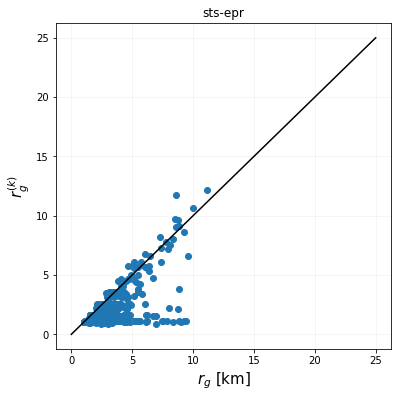

In [93]:
# compute rg and k-rg for sts-epr

synt_data = synt_dict["sts-epr"]

rg_syn = list(radius_of_gyration(synt_data, show_progress=False)["radius_of_gyration"])
k2rg_syn = list(k_radius_of_gyration(synt_data, k=2, show_progress=False)["2k_radius_of_gyration"])

fig = plt.figure(figsize=(6, 6))
plt.title("sts-epr")
plt.scatter(rg_syn, k2rg_syn, marker='o')
plt.xlabel('$r_g$ [km]', fontsize=15)
plt.ylabel('$r_g^{(k)}$', fontsize=15)
plt.grid(alpha=0.15)
plt.plot([0, 25], [0, 25], color="black")
plt.show()